In [2]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel, f_oneway,ttest_1samp
from dataset import *

from statsmodels.stats.anova import AnovaRM # perform F test

In [3]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'

conn_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/connectivity'
if not Path(conn_dir).exists():
    conn_dir = '/srv/diedrichsen/data/Cerebellum/connectivity'
if not Path(conn_dir).exists():
    conn_dir = '/cifs/diedrichsen/data/Cerebellum/connectivity'


In [4]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1,hue_order = ['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence']):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50,hue_order=['consonant_string','pseudoword_list','jabberwocky','word_list','simple_sentence','complex_sentence'])
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = vcdf_preped['X'], 
                        y = vcdf_preped['Y'], 
                        yerr = vcdf_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')


In [4]:
# load the dataframe for the whole 
df_path = os.path.join(conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_whole.tsv")
df = pd.read_csv(df_path, sep="\t")
df = df[df['cond_name'] != 'probe']

df_averaged = df.groupby(['sn', 'cond_name']).mean()
df_averaged = df_averaged.drop(columns=['half','res','coef','R2'])
df_averaged = df_averaged.reset_index()
df_averaged


/tmp/ipykernel_12065/39523517.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = df.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y,#region
0,sub-01,complex_sentence,190.0,1.0,28.0,1.0,-0.107489,-0.078870,1.0
1,sub-01,consonant_string,191.0,1.0,29.0,2.0,-0.080986,-0.062980,1.0
2,sub-01,jabberwocky,192.0,1.0,30.0,3.0,-0.122244,-0.083705,1.0
3,sub-01,pseudoword_list,194.0,1.0,32.0,5.0,-0.105407,-0.070380,1.0
4,sub-01,simple_sentence,195.0,1.0,33.0,6.0,-0.104450,-0.087182,1.0
...,...,...,...,...,...,...,...,...,...
67,sub-15,consonant_string,191.0,1.0,29.0,2.0,0.010206,-0.040064,1.0
68,sub-15,jabberwocky,192.0,1.0,30.0,3.0,-0.005127,-0.047141,1.0
69,sub-15,pseudoword_list,194.0,1.0,32.0,5.0,0.004884,-0.041798,1.0
70,sub-15,simple_sentence,195.0,1.0,33.0,6.0,-0.011797,-0.057083,1.0


/tmp/ipykernel_12065/3121395095.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


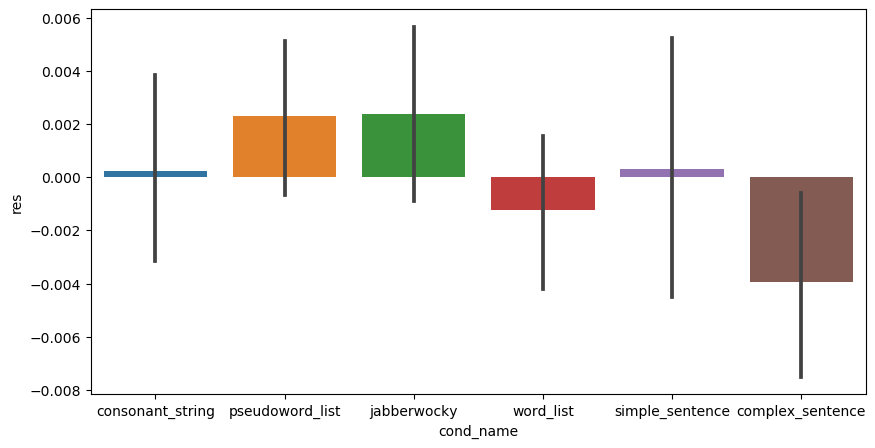

In [6]:
df_residuals = df_averaged.copy()

#create new columns to store the slope and intercept
df_residuals['slope'] = np.nan
df_residuals['intercept'] = np.nan

#group the dataframe by sn
sn_groups = df_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    df_residuals.loc[df_residuals['sn'] == name, 'slope'] = slope
    df_residuals.loc[df_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in df_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    df_residuals.loc[index, 'Y_pred'] = Y_pred
    df_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=df_residuals,x='cond_name',y='res', order= ['consonant_string','pseudoword_list','jabberwocky','word_list','simple_sentence','complex_sentence'])

In [9]:
# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)


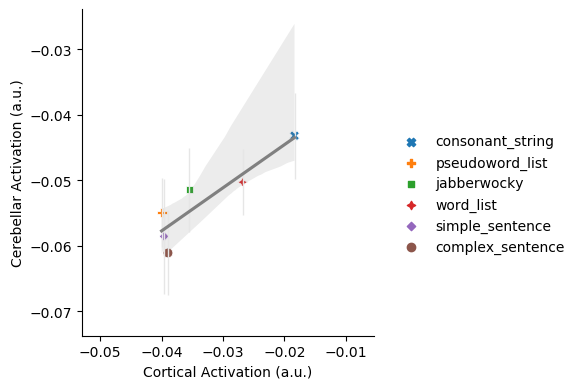

In [10]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [20]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  1.3125 5.0000 55.0000 0.2723



# ROI based analysis (WordRead-MDTB roi)

In [12]:
rdf_path = os.path.join(conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_WordRead.tsv")
rdf = pd.read_csv(rdf_path, sep="\t")
rdf = rdf[rdf['cond_name'] != 'probe']

rdf_averaged = rdf.groupby(['sn', 'cond_name']).mean()
rdf_averaged = rdf_averaged.drop(columns=['half','res','coef','R2'])
rdf_averaged = rdf_averaged.reset_index()
rdf_averaged


/tmp/ipykernel_12065/1113440237.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf_averaged = rdf.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y,#region
0,sub-01,complex_sentence,190.0,1.0,28.0,1.0,-0.107614,-0.084052,1.0
1,sub-01,consonant_string,191.0,1.0,29.0,2.0,-0.143244,-0.093014,1.0
2,sub-01,jabberwocky,192.0,1.0,30.0,3.0,-0.136420,-0.103317,1.0
3,sub-01,pseudoword_list,194.0,1.0,32.0,5.0,-0.126778,-0.086135,1.0
4,sub-01,simple_sentence,195.0,1.0,33.0,6.0,-0.107437,-0.097872,1.0
...,...,...,...,...,...,...,...,...,...
67,sub-15,consonant_string,191.0,1.0,29.0,2.0,-0.030055,-0.079017,1.0
68,sub-15,jabberwocky,192.0,1.0,30.0,3.0,-0.021109,-0.078033,1.0
69,sub-15,pseudoword_list,194.0,1.0,32.0,5.0,-0.010204,-0.072435,1.0
70,sub-15,simple_sentence,195.0,1.0,33.0,6.0,-0.017612,-0.078571,1.0


/tmp/ipykernel_12065/1791092540.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in r_sn_groups:


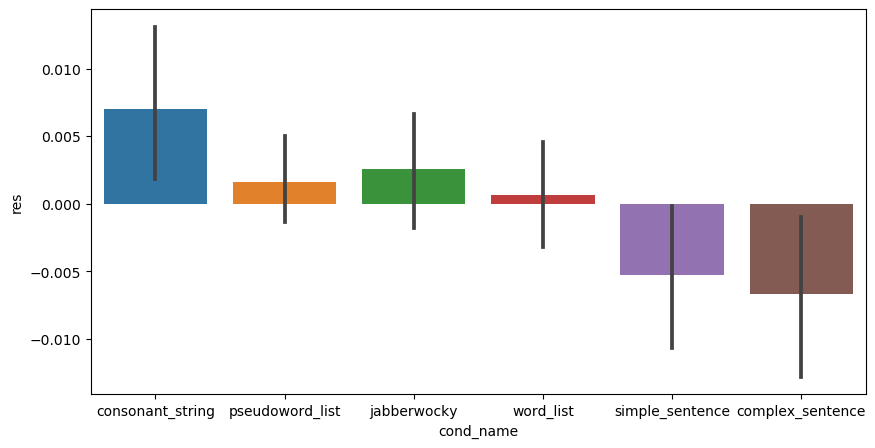

In [13]:
rdf_residuals = rdf_averaged.copy()

#create new columns to store the slope and intercept
rdf_residuals['slope'] = np.nan
rdf_residuals['intercept'] = np.nan

#group the dataframe by sn
r_sn_groups = rdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in r_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    rdf_residuals.loc[rdf_residuals['sn'] == name, 'slope'] = slope
    rdf_residuals.loc[rdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in rdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    rdf_residuals.loc[index, 'Y_pred'] = Y_pred
    rdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=rdf_residuals,x='cond_name',y='res', order=['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence'])

In [14]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
rdf_preped = prep_df(rdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

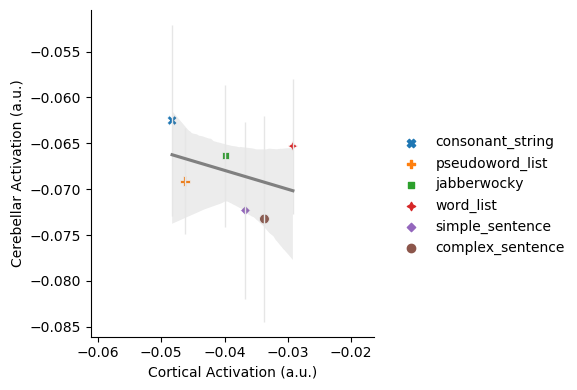

In [15]:
make_plot(rdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [25]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=rdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  3.2922 5.0000 55.0000 0.0113



# ROI based analysis (VerbGen-MDTB roi)

In [21]:
vrdf_path = os.path.join(conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_VerbGen.tsv")
vrdf = pd.read_csv(vrdf_path, sep="\t")
vrdf = vrdf[vrdf['cond_name'] != 'probe']

vrdf_averaged = vrdf.groupby(['sn', 'cond_name']).mean()
vrdf_averaged = vrdf_averaged.drop(columns=['half','res','coef','R2'])
vrdf_averaged = vrdf_averaged.reset_index()
vrdf_averaged

/tmp/ipykernel_12065/3423321968.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vrdf_averaged = vrdf.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y,#region
0,sub-01,complex_sentence,190.0,1.0,28.0,1.0,-0.087410,-0.056298,1.0
1,sub-01,consonant_string,191.0,1.0,29.0,2.0,-0.096375,-0.085093,1.0
2,sub-01,jabberwocky,192.0,1.0,30.0,3.0,-0.097370,-0.077506,1.0
3,sub-01,pseudoword_list,194.0,1.0,32.0,5.0,-0.094227,-0.066858,1.0
4,sub-01,simple_sentence,195.0,1.0,33.0,6.0,-0.085964,-0.072428,1.0
...,...,...,...,...,...,...,...,...,...
67,sub-15,consonant_string,191.0,1.0,29.0,2.0,0.008030,-0.058071,1.0
68,sub-15,jabberwocky,192.0,1.0,30.0,3.0,0.021988,-0.058907,1.0
69,sub-15,pseudoword_list,194.0,1.0,32.0,5.0,0.019309,-0.057081,1.0
70,sub-15,simple_sentence,195.0,1.0,33.0,6.0,0.005732,-0.058537,1.0


/tmp/ipykernel_12065/2386236542.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in vr_sn_groups:


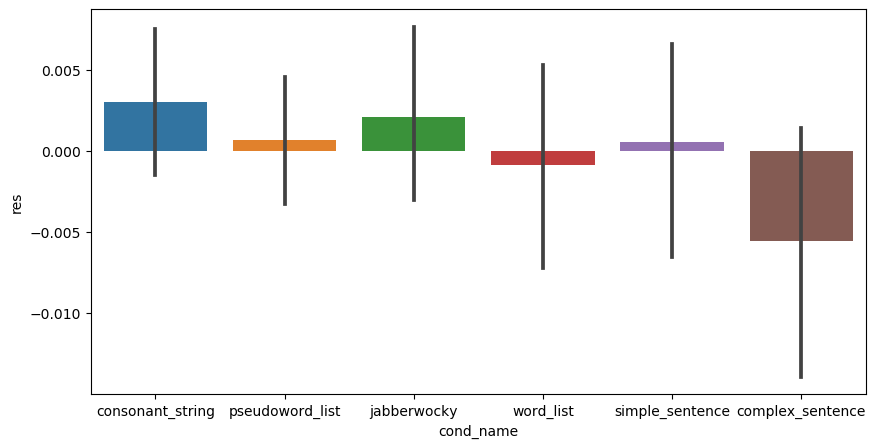

In [22]:
vrdf_residuals = vrdf_averaged.copy()

#create new columns to store the slope and intercept
vrdf_residuals['slope'] = np.nan
vrdf_residuals['intercept'] = np.nan

#group the dataframe by sn
vr_sn_groups = vrdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in vr_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    vrdf_residuals.loc[vrdf_residuals['sn'] == name, 'slope'] = slope
    vrdf_residuals.loc[vrdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in vrdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    vrdf_residuals.loc[index, 'Y_pred'] = Y_pred
    vrdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=vrdf_residuals,x='cond_name',y='res',order=['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence'])

In [23]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
vrdf_preped = prep_df(vrdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

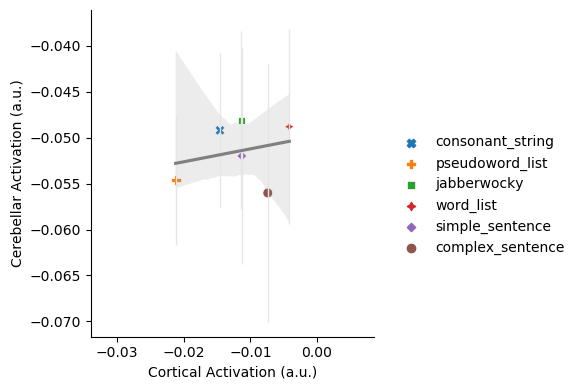

In [26]:
make_plot(vrdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [30]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=vrdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.8327 5.0000 55.0000 0.5321



# ROI (Speech vs non_speech from IBC-archi)

In [28]:
srdf_path = os.path.join(conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_speechvsnonspeech.tsv")
srdf = pd.read_csv(srdf_path, sep="\t")
srdf = srdf[srdf['cond_name'] != 'probe']

srdf_averaged = srdf.groupby(['sn', 'cond_name']).mean()
srdf_averaged = srdf_averaged.drop(columns=['half','res','coef','R2'])
srdf_averaged = srdf_averaged.reset_index()
srdf_averaged

/tmp/ipykernel_12065/4167423617.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  srdf_averaged = srdf.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y,#region
0,sub-01,complex_sentence,190.0,1.0,28.0,1.0,-0.116822,-0.074438,1.0
1,sub-01,consonant_string,191.0,1.0,29.0,2.0,-0.075515,-0.053580,1.0
2,sub-01,jabberwocky,192.0,1.0,30.0,3.0,-0.134321,-0.081759,1.0
3,sub-01,pseudoword_list,194.0,1.0,32.0,5.0,-0.113458,-0.065960,1.0
4,sub-01,simple_sentence,195.0,1.0,33.0,6.0,-0.115648,-0.081008,1.0
...,...,...,...,...,...,...,...,...,...
67,sub-15,consonant_string,191.0,1.0,29.0,2.0,-0.002817,-0.028561,1.0
68,sub-15,jabberwocky,192.0,1.0,30.0,3.0,-0.017782,-0.032808,1.0
69,sub-15,pseudoword_list,194.0,1.0,32.0,5.0,-0.007125,-0.029840,1.0
70,sub-15,simple_sentence,195.0,1.0,33.0,6.0,-0.020596,-0.044356,1.0


/tmp/ipykernel_12065/1180209445.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sr_sn_groups:


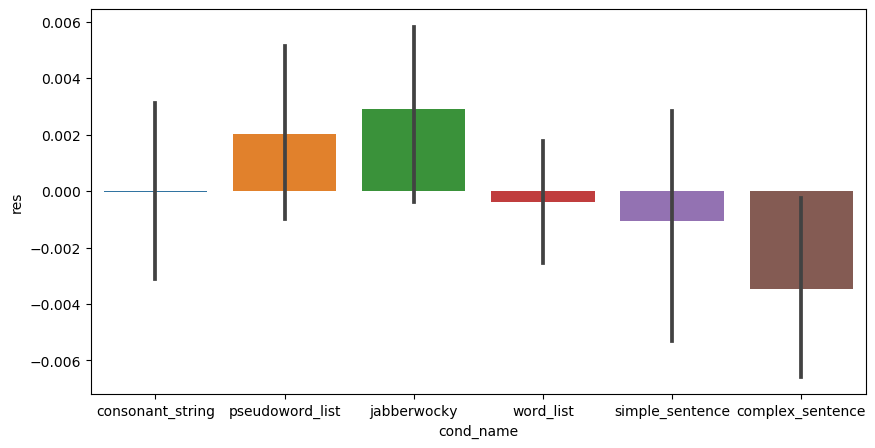

In [29]:
srdf_residuals = srdf_averaged.copy()

#create new columns to store the slope and intercept
srdf_residuals['slope'] = np.nan
srdf_residuals['intercept'] = np.nan

#group the dataframe by sn
sr_sn_groups = srdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in sr_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    srdf_residuals.loc[srdf_residuals['sn'] == name, 'slope'] = slope
    srdf_residuals.loc[srdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in srdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    srdf_residuals.loc[index, 'Y_pred'] = Y_pred
    srdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=srdf_residuals,x='cond_name',y='res',order=['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence'])

In [30]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
srdf_preped = prep_df(srdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

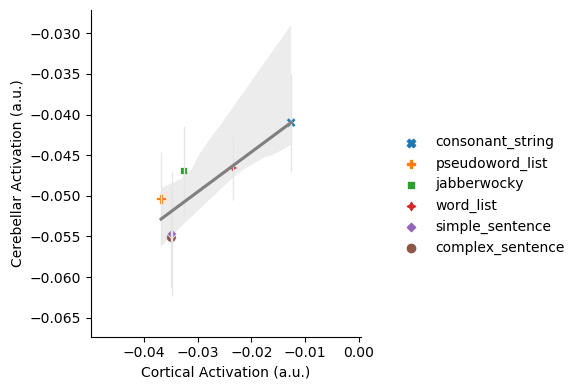

In [31]:
make_plot(srdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [32]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=srdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  1.4782 5.0000 55.0000 0.2119



# CONNECTIVITY wordread MDTB-S1

In [36]:
# load the dataframe for the whole 
cdf_path = os.path.join(conn_dir, "IBC", "sc_conn_MDTB_IBC_ses-rsvplanguage_WordRead.tsv")
cdf = pd.read_csv(cdf_path, sep="\t")
cdf = cdf[cdf['cond_name'] != 'probe']

cdf_averaged = cdf.groupby(['sn', 'cond_name']).mean()
cdf_averaged = cdf_averaged.drop(columns=['half','res','coef','R2'])
cdf_averaged = cdf_averaged.reset_index()
cdf_averaged

/tmp/ipykernel_12065/1758706521.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cdf_averaged = cdf.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y,#region
0,sub-01,complex_sentence,190.0,1.0,28.0,1.0,-0.003454,-0.084052,1.0
1,sub-01,consonant_string,191.0,1.0,29.0,2.0,-0.009441,-0.093014,1.0
2,sub-01,jabberwocky,192.0,1.0,30.0,3.0,-0.005956,-0.103317,1.0
3,sub-01,pseudoword_list,194.0,1.0,32.0,5.0,-0.007228,-0.086135,1.0
4,sub-01,simple_sentence,195.0,1.0,33.0,6.0,-0.003156,-0.097872,1.0
...,...,...,...,...,...,...,...,...,...
67,sub-15,consonant_string,191.0,1.0,29.0,2.0,-0.003857,-0.079017,1.0
68,sub-15,jabberwocky,192.0,1.0,30.0,3.0,-0.000331,-0.078033,1.0
69,sub-15,pseudoword_list,194.0,1.0,32.0,5.0,0.000135,-0.072435,1.0
70,sub-15,simple_sentence,195.0,1.0,33.0,6.0,0.001308,-0.078571,1.0


/tmp/ipykernel_12065/3031926660.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in c_sn_groups:


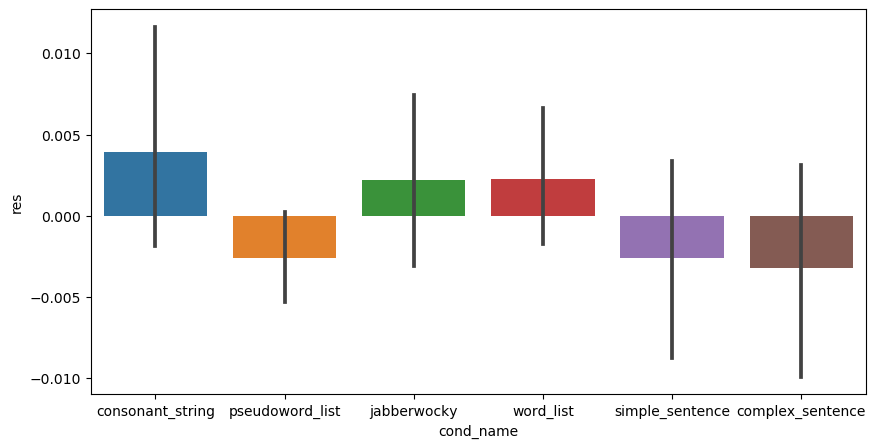

In [37]:
cdf_residuals = cdf_averaged.copy()

#create new columns to store the slope and intercept
cdf_residuals['slope'] = np.nan
cdf_residuals['intercept'] = np.nan

#group the dataframe by sn
c_sn_groups = cdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in c_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    cdf_residuals.loc[cdf_residuals['sn'] == name, 'slope'] = slope
    cdf_residuals.loc[cdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in cdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    cdf_residuals.loc[index, 'Y_pred'] = Y_pred
    cdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=cdf_residuals,x='cond_name',y='res',order=['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence'])

In [38]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
cdf_preped = prep_df(cdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

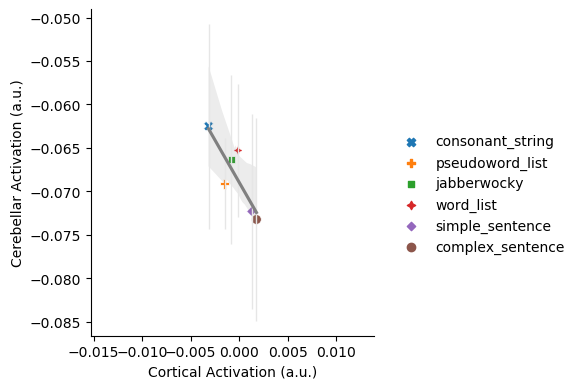

In [39]:
make_plot(cdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [1]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=cdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

NameError: name 'AnovaRM' is not defined

# Connectivity VerbGen MDTB-s1

In [12]:
# load the dataframe for the whole 
vcdf_path = os.path.join(conn_dir, "IBC", "sc_conn_MDTB_IBC_ses-rsvplanguage_VerbGen.tsv")
vcdf = pd.read_csv(vcdf_path, sep="\t")
vcdf = vcdf[vcdf['cond_name'] != 'probe']

vcdf_averaged = vcdf.groupby(['sn', 'cond_name']).mean()
vcdf_averaged = vcdf_averaged.drop(columns=['half','res','coef','R2'])
vcdf_averaged = vcdf_averaged.reset_index()
vcdf_averaged

/tmp/ipykernel_17222/2860531397.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vcdf_averaged = vcdf.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y,#region
0,sub-01,complex_sentence,190.0,1.0,28.0,1.0,0.001599,-0.056298,1.0
1,sub-01,consonant_string,191.0,1.0,29.0,2.0,-0.002373,-0.085093,1.0
2,sub-01,jabberwocky,192.0,1.0,30.0,3.0,0.001693,-0.077506,1.0
3,sub-01,pseudoword_list,194.0,1.0,32.0,5.0,-0.002632,-0.066858,1.0
4,sub-01,simple_sentence,195.0,1.0,33.0,6.0,0.002166,-0.072428,1.0
...,...,...,...,...,...,...,...,...,...
67,sub-15,consonant_string,191.0,1.0,29.0,2.0,0.003137,-0.058071,1.0
68,sub-15,jabberwocky,192.0,1.0,30.0,3.0,0.007836,-0.058907,1.0
69,sub-15,pseudoword_list,194.0,1.0,32.0,5.0,0.005761,-0.057081,1.0
70,sub-15,simple_sentence,195.0,1.0,33.0,6.0,0.007089,-0.058537,1.0


/tmp/ipykernel_17222/2914257221.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in vc_sn_groups:


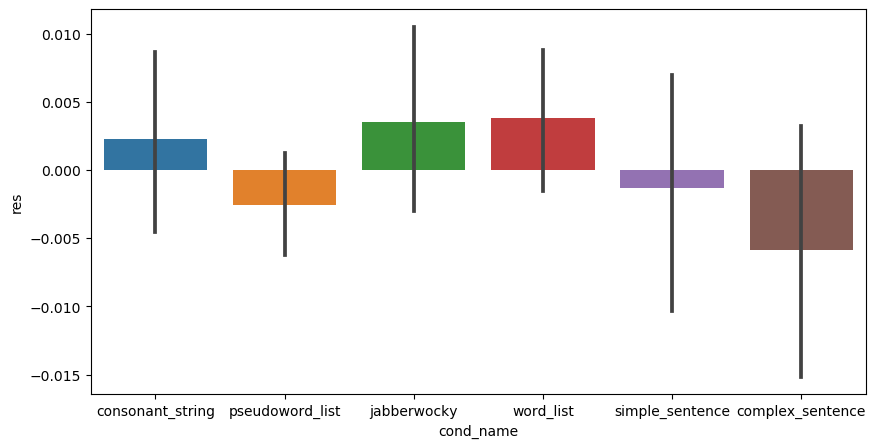

In [13]:
vcdf_residuals = vcdf_averaged.copy()

#create new columns to store the slope and intercept
vcdf_residuals['slope'] = np.nan
vcdf_residuals['intercept'] = np.nan

#group the dataframe by sn
vc_sn_groups = vcdf_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in vc_sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    vcdf_residuals.loc[vcdf_residuals['sn'] == name, 'slope'] = slope
    vcdf_residuals.loc[vcdf_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in vcdf_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    vcdf_residuals.loc[index, 'Y_pred'] = Y_pred
    vcdf_residuals.loc[index, 'res'] = res


plt.figure(figsize=(10, 5))
sns.barplot(data=vcdf_residuals,x='cond_name',y='res',order=['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence'])

In [14]:
#prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
vcdf_preped = prep_df(vcdf_residuals ,groupby = "cond_name", agg_kw=agg_kw)

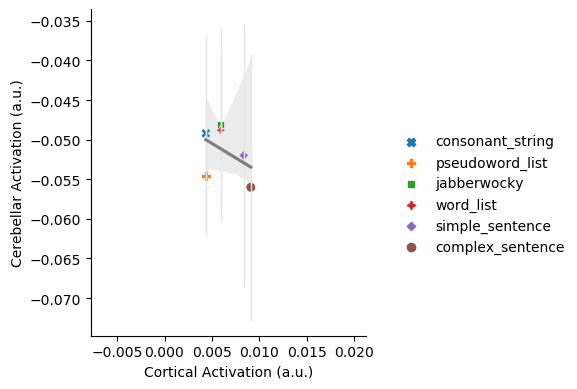

In [15]:
make_plot(vcdf_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [16]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=vcdf_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.8936 5.0000 55.0000 0.4919

